In [1]:
from nltk.tokenize import word_tokenize, sent_tokenize 
from nltk import pos_tag
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import itertools
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
import pickle
from numpy.random import shuffle

In [2]:
with open('reviews.pkl', 'rb') as handle:
    data = pickle.load(handle)
titles = list(data.keys())
shuffle(titles)
train_titles = titles[:250]
test_titles = titles[250:]

In [3]:
len(titles)

295

In [4]:
reviews = []
ratings = []
vocab = []
lengths = []
review_counts = {}
for each_title in titles:
    r_pair = data[each_title]
    count = 0
    for each_pair in r_pair:
        if each_pair[1] != '0':
            reviews.append(each_pair[0])
            ratings.append(int(each_pair[1]))
            vocab += each_pair[0].split()
            lengths.append(len(each_pair[0].split()))
            count += 1
    review_counts[each_title] = count

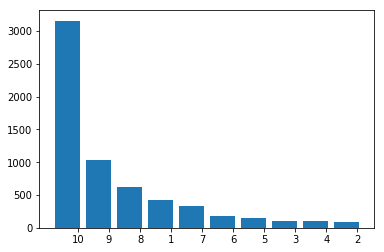

In [5]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

word_list = ratings
counts = Counter(word_list)
labels, values = zip(*counts.items())
indSort = np.argsort(values)[::-1]
labels = np.array(labels)[indSort]
values = np.array(values)[indSort]
indexes = np.arange(len(labels))

bar_width = 0.35

plt.bar(indexes, values)

plt.xticks(indexes + bar_width, labels)
plt.show()

In [6]:
len(reviews)

6174

In [7]:
def cleanme(txt):
    sent = txt.lower()
    wrds = word_tokenize(sent)
    clwrds = [w for w in wrds if not w in stopwords.words('english')]
    ln = len(clwrds)
    pos = pd.DataFrame(pos_tag(wrds))
    pos = " ".join(list(pos[pos[1].str.contains("JJ")].iloc[:,0]))
    rt = [ln, " ".join(clwrds), pos]
    return(rt)

In [8]:
vect = TfidfVectorizer(ngram_range = (1,2))
x_vect1 = vect.fit_transform(reviews)

In [9]:
movie_vec = {}
test_count = 0
train_count = 0
g_count = 0
for each_title in train_titles:
    movie_vec[each_title] = x_vect1[g_count : g_count+review_counts[each_title]]
    g_count += review_counts[each_title] 
    
train_count = g_count
for each_title in test_titles:
    movie_vec[each_title] = x_vect1[g_count : g_count+review_counts[each_title]]
    g_count += review_counts[each_title] 
test_count = g_count - train_count

In [10]:
print(train_count,test_count)

5255 919


In [13]:
def linsvc(x,y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state = 10)
    classf = LinearSVC(class_weight='balanced')
    classf.fit(x_train, y_train)
    pred = classf.predict(x_train)
    print("Linear SVC Train Accuracy:",accuracy_score(y_train, pred))
    pred = classf.predict(x_test)
    print("Linear SVC Test Accuracy:",accuracy_score(y_test, pred))
    return(y_test, pred, classf)

def revknn(x,y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state = 10)
    classf = KNeighborsClassifier(n_neighbors=2)
    classf.fit(x_train, y_train)
    pred = classf.predict(x_train)
    print("KNN Train Accuracy:",accuracy_score(y_train, pred))
    pred = classf.predict(x_test)
    print("KNN Test Accuracy:",accuracy_score(y_test, pred))
    return(y_test, pred, classf)

def revnb(x,y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state = 10)
    classf = MultinomialNB()
    classf.fit(x_train, y_train)
    pred = classf.predict(x_train)
    print("NB Train Accuracy:",accuracy_score(y_train, pred))
    pred = classf.predict(x_test)
    print("NB Test Accuracy:",accuracy_score(y_test, pred))
    return(y_test, pred, classf)

In [14]:
y = ratings
svmy1,svmp1,SVMclf = linsvc(x_vect1[:train_count],y[:train_count])

knny1,knnp1, KNNclf = revknn(x_vect1[:train_count],y[:train_count])

nby1,nbp1, NBclf = revnb(x_vect1[:train_count],y[:train_count])

Linear SVC Train Accuracy: 1.0
Linear SVC Test Accuracy: 0.5616438356164384
KNN Train Accuracy: 0.7665567114945445
KNN Test Accuracy: 0.3059360730593607
NB Train Accuracy: 0.5135752347120021
NB Test Accuracy: 0.5197869101978692


In [15]:
import statistics
for each_title in test_titles[:10]:
    rtgs = []
    for each_pair in data[each_title]:
        if each_pair[1] != '0':
            rtgs.append(int(each_pair[1]))
    if movie_vec[each_title].shape[0] > 1:
        svm_preds = SVMclf.predict(movie_vec[each_title])
        knn_preds = KNNclf.predict(movie_vec[each_title])
        nb_preds = NBclf.predict(movie_vec[each_title])
        print('Movie Title: ', each_title)
        print('=====>Actual Rating:',statistics.mean(rtgs))
        print('=====>SVM rating:',np.mean(svm_preds),'KNN rating:',np.mean(knn_preds),'NB rating:',np.mean(nb_preds))
        print('\n\n')

Movie Title:  Salinui chueok (2003)
=====>Actual Rating: 8.869565217391305
=====>SVM rating: 9.521739130434783 KNN rating: 7.043478260869565 NB rating: 10.0



Movie Title:  Vergiss mein nicht (2004)
=====>Actual Rating: 7.6521739130434785
=====>SVM rating: 9.08695652173913 KNN rating: 8.73913043478261 NB rating: 10.0



Movie Title:  Rang De Basanti (2006)
=====>Actual Rating: 7.88
=====>SVM rating: 9.64 KNN rating: 8.68 NB rating: 10.0



Movie Title:  Das Schweigen der Lämmer (1991)
=====>Actual Rating: 9.777777777777779
=====>SVM rating: 9.944444444444445 KNN rating: 8.5 NB rating: 10.0



Movie Title:  Oldboy (2003)
=====>Actual Rating: 6.791666666666667
=====>SVM rating: 8.083333333333334 KNN rating: 9.291666666666666 NB rating: 10.0



Movie Title:  Der eiskalte Engel (1967)
=====>Actual Rating: 7.454545454545454
=====>SVM rating: 7.7727272727272725 KNN rating: 7.681818181818182 NB rating: 10.0



Movie Title:  Mord - Sir John greift ein! (1930)
=====>Actual Rating: 6.6818181818

In [16]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

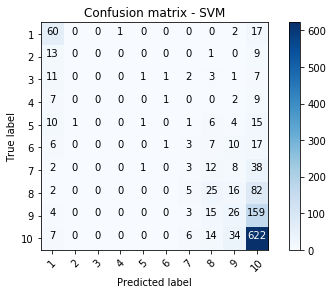

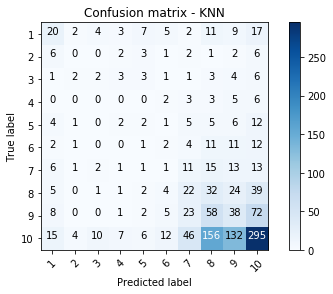

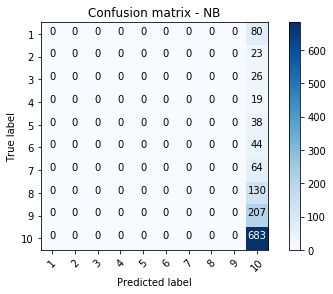

In [17]:
c1 = confusion_matrix(svmy1,svmp1)
c2 = confusion_matrix(knny1,knnp1)
c3 = confusion_matrix(nby1,nbp1)
class_names = ['1', '2', '3', '4', '5','6','7','8','9','10']
plt.figure()
plot_confusion_matrix(c1, classes=class_names,title='Confusion matrix - SVM')
plt.figure()
plot_confusion_matrix(c2, classes=class_names,title='Confusion matrix - KNN')
plt.figure()
plot_confusion_matrix(c3, classes=class_names,title='Confusion matrix - NB')
